# 3D Segmentation with UNet

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/KitwareMedical/tensorboard-plugin-3d/blob/main/demo/notebook/unet_segmentation_3d_ignite.ipynb)

## Setup environment

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[ignite, nibabel, tensorboard, mlflow]"

In [ ]:
# install the tensorboard 3d plugin for the tutorial
!pip install -q tensorboard-plugin-3d

## Setup imports

In [ ]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import glob
import logging
import os
from pathlib import Path
import shutil
import sys
import tempfile

import nibabel as nib
import numpy as np
from monai.config import print_config
from monai.data import ArrayDataset, create_test_image_3d, decollate_batch
from monai.handlers import (
    MeanDice,
    MLFlowHandler,
    StatsHandler,
    TensorBoardImageHandler,
    TensorBoardStatsHandler,
)
from monai.losses import DiceLoss
from monai.networks.nets import UNet
from monai.transforms import (
    Activations,
    AddChannel,
    AsDiscrete,
    Compose,
    LoadImage,
    RandSpatialCrop,
    Resize,
    ScaleIntensity,
    EnsureType,
)
from monai.inferers import sliding_window_inference
from monai.utils import first
from monai.visualize import plot_2d_or_3d_image

import ignite
import torch
from torch.utils.tensorboard import SummaryWriter

print_config()

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [ ]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

## Setup logging

In [ ]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

## Setup demo data

In [ ]:
for i in range(40):
    im, seg = create_test_image_3d(128, 128, 128, num_seg_classes=1)

    n = nib.Nifti1Image(im, np.eye(4))
    nib.save(n, os.path.join(root_dir, f"im{i}.nii.gz"))

    n = nib.Nifti1Image(seg, np.eye(4))
    nib.save(n, os.path.join(root_dir, f"seg{i}.nii.gz"))

images = sorted(glob.glob(os.path.join(root_dir, "im*.nii.gz")))
segs = sorted(glob.glob(os.path.join(root_dir, "seg*.nii.gz")))

## Setup transforms, dataset

In [ ]:
# Define transforms for image and segmentation
imtrans = Compose(
    [
        LoadImage(image_only=True),
        ScaleIntensity(),
        AddChannel(),
        RandSpatialCrop((96, 96, 96), random_size=False),
        EnsureType(),
    ]
)
segtrans = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(),
        RandSpatialCrop((96, 96, 96), random_size=False),
        EnsureType(),
    ]
)

# Define nifti dataset, dataloader
ds = ArrayDataset(images, imtrans, segs, segtrans)
loader = torch.utils.data.DataLoader(
    ds, batch_size=10, num_workers=2, pin_memory=torch.cuda.is_available()
)
im, seg = first(loader)
print(im.shape, seg.shape)

## Create Model, Loss, Optimizer

In [ ]:
# Create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
net = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

loss = DiceLoss(sigmoid=True)
lr = 1e-3
opt = torch.optim.Adam(net.parameters(), lr)

## Create supervised_trainer using ignite

In [ ]:
# Create trainer
trainer = ignite.engine.create_supervised_trainer(
    net, opt, loss, device, False
)

## Setup event handlers for checkpointing and logging

In [ ]:
# optional section for checkpoint and tensorboard logging
# adding checkpoint handler to save models (network
# params and optimizer stats) during training
log_dir = os.path.join(root_dir, "logs")
checkpoint_handler = ignite.handlers.ModelCheckpoint(
    log_dir, "net", n_saved=10, require_empty=False
)
trainer.add_event_handler(
    event_name=ignite.engine.Events.EPOCH_COMPLETED,
    handler=checkpoint_handler,
    to_save={"net": net, "opt": opt},
)

# StatsHandler prints loss at every iteration
# user can also customize print functions and can use output_transform to convert
# engine.state.output if it's not a loss value
train_stats_handler = StatsHandler(name="trainer", output_transform=lambda x: x)
train_stats_handler.attach(trainer)

# TensorBoardStatsHandler plots loss at every iteration
train_tensorboard_stats_handler = TensorBoardStatsHandler(log_dir=log_dir, output_transform=lambda x: x)
train_tensorboard_stats_handler.attach(trainer)

# MLFlowHandler plots loss at every iteration on MLFlow web UI
mlflow_dir = os.path.join(log_dir, "mlruns")
train_mlflow_handler = MLFlowHandler(tracking_uri=Path(mlflow_dir).as_uri(), output_transform=lambda x: x)
train_mlflow_handler.attach(trainer)

## Add Validation every N epochs

In [ ]:
# optional section for model validation during training
validation_every_n_epochs = 1
# Set parameters for validation
metric_name = "Mean_Dice"
# add evaluation metric to the evaluator engine
val_metrics = {metric_name: MeanDice()}
post_pred = Compose(
    [EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold=0.5)]
)
post_label = Compose([EnsureType(), AsDiscrete(threshold_values=True)])
# Ignite evaluator expects batch=(img, seg) and
# returns output=(y_pred, y) at every iteration,
# user can add output_transform to return other values
evaluator = ignite.engine.create_supervised_evaluator(
    net,
    val_metrics,
    device,
    True,
    output_transform=lambda x, y, y_pred: (
        [post_pred(i) for i in decollate_batch(y_pred)],
        [post_label(i) for i in decollate_batch(y)]
    ),
)

# create a validation data loader
val_imtrans = Compose(
    [
        LoadImage(image_only=True),
        ScaleIntensity(),
        AddChannel(),
        Resize((96, 96, 96)),
        EnsureType(),
    ]
)
val_segtrans = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(),
        Resize((96, 96, 96)),
        EnsureType(),
    ]
)
val_ds = ArrayDataset(images[21:], val_imtrans, segs[21:], val_segtrans)
val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=5, num_workers=8, pin_memory=torch.cuda.is_available()
)


@trainer.on(
    ignite.engine.Events.EPOCH_COMPLETED(every=validation_every_n_epochs)
)
def run_validation(engine):
    evaluator.run(val_loader)


# Add stats event handler to print validation stats via evaluator
val_stats_handler = StatsHandler(
    name="evaluator",
    # no need to print loss value, so disable per iteration output
    output_transform=lambda x: None,
    # fetch global epoch number from trainer
    global_epoch_transform=lambda x: trainer.state.epoch,
)
val_stats_handler.attach(evaluator)

# add handler to record metrics to TensorBoard at every validation epoch
val_tensorboard_stats_handler = TensorBoardStatsHandler(
    log_dir=log_dir,
    # no need to plot loss value, so disable per iteration output
    output_transform=lambda x: None,
    # fetch global epoch number from trainer
    global_epoch_transform=lambda x: trainer.state.epoch,
)
val_tensorboard_stats_handler.attach(evaluator)

# add handler to record metrics to MLFlow at every validation epoch
val_mlflow_handler = MLFlowHandler(
    tracking_uri=Path(mlflow_dir).as_uri(),
    # no need to plot loss value, so disable per iteration output
    output_transform=lambda x: None,
    # fetch global epoch number from trainer
    global_epoch_transform=lambda x: trainer.state.epoch,
)
val_mlflow_handler.attach(evaluator)

## Run training loop

In [ ]:
# create a training data loader
train_ds = ArrayDataset(images[:20], imtrans, segs[:20], segtrans)
train_loader = torch.utils.data.DataLoader(
    train_ds,
    batch_size=5,
    shuffle=True,
    num_workers=8,
    pin_memory=torch.cuda.is_available(),
)

max_epochs = 10
state = trainer.run(train_loader, max_epochs)

## Visualizing TensorBoard logs
### Check best model output using TensorBoard and TensorBoardPlugin3D
MONAI provides `plot_2d_or_3d_image` and the related ignite handler to plot the 3D image in TensorBoard.

In [ ]:
net.eval()
val_loader_data = [data for data in val_loader]
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_data = val_loader_data[0]
    roi_size = (160, 160, 160)
    sw_batch_size = 4
    val_outputs = sliding_window_inference(
        val_data[0].to(device), roi_size, sw_batch_size, net
    )
    # Visualize the first output image
    plot_2d_or_3d_image(data=val_outputs, step=0, writer=SummaryWriter(log_dir=log_dir), frame_dim=-1, tag="image")

In [ ]:
# Note: plot_2d_or_3d_image may take some time to write the required event file. If the "TensorBoard 3D" tab is not immediately available wait a minute and then re-run this cell.
%load_ext tensorboard
%tensorboard --logdir=$log_dir

Expected training curve on TensorBoard:

![Training Curve.png](../images/training_curve.png)

Expected output image:

![UNet Images.png](../images/unet_images.png)

Expected output image in 3D plugin:

![UNet Plugin.png](../images/unet_plugin.png)

## Visualizing training status in MLFlow

As `mlflow` is not IPython component, please switch to the `log_dir` and execute command `mlflow ui` to launch MLFlow UI.

Expected training curve on MLFlow UI:
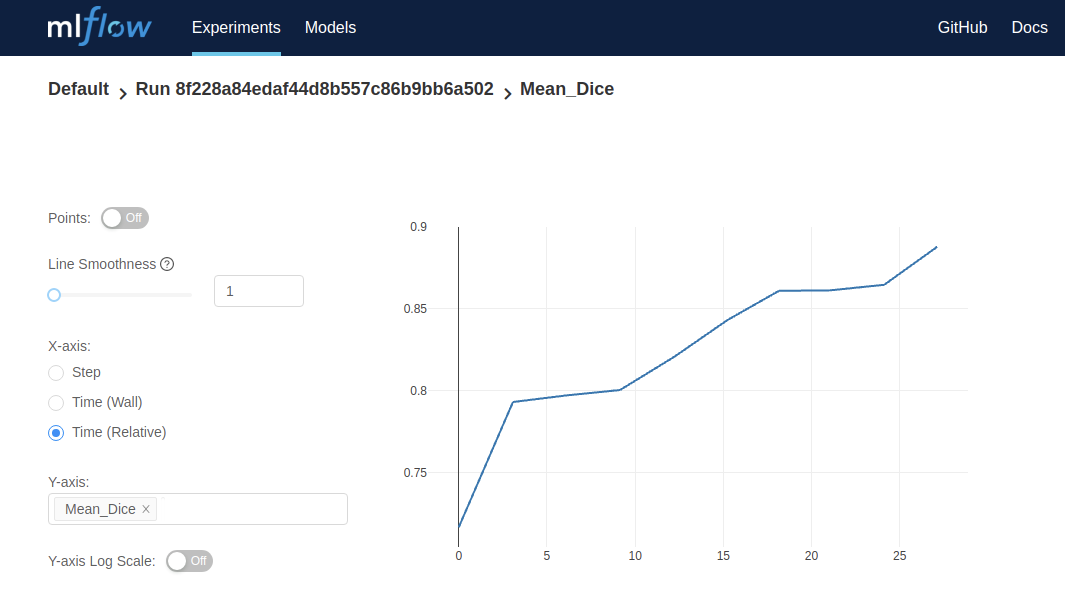

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
# if directory is None:
#     shutil.rmtree(root_dir)